##  20-class subset of CIFAR-100



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
%matplotlib inline


import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#loading data

from sklearn.model_selection import train_test_split
cifar100 = keras.datasets.cifar100
(X_train_full, y_train_full), (X_test, y_test) = cifar100.load_data()



169017344/169001437 [==============================] - 14s 0us/step


In [ ]:
X_train_full.shape

(50000, 32, 32, 3)

In [ ]:
#Conversion map
fine_id_coarse_id_map = {
    0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7, 8: 18, 9: 3, 10: 3, 11: 14, 12: 9, 13: 18,
    14: 7, 15:11, 16:3, 17: 9, 18: 7, 19: 11, 20: 6,21: 11,22:5, 23:10,24:7,25:6,26:13,27:15,28: 3,
    29: 15,30: 0,31: 11,32: 1, 33: 10, 34: 12,35: 14, 36: 16, 37: 9, 38: 11, 39: 5, 40: 5, 41: 19,42: 8,
    43: 8,44: 15, 45: 13, 46: 14,47: 17,48: 18,49: 10,50: 16,51: 4,52: 17,53: 4,54: 2,55: 0,56: 17,57: 4,
    58: 18,59: 17,60: 10,61: 3,62: 2,63: 12,64: 12,65: 16,66: 12,67: 1,68: 9,69: 19,70: 2,71: 10,72: 0,73: 1,
    74: 16,75: 12,76: 9,77: 13,78: 15,79: 13,80:16, 81:19, 82: 2,83: 4,84: 6,85: 19,86:5,87:5,88:8,89:19,
    90: 18, 91: 1,92: 2,93: 15,94: 6,95: 0,96: 17,97: 8,98: 14, 99: 13
    }

In [ ]:
{k: v for k, v in sorted(fine_id_coarse_id_map.items(), key=lambda item: item[1])}

#https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value

In [ ]:
#Subset of classes with one class from each superclass$es

subset_dict={ 30: 0, 1: 1, 54: 2, 9: 3, 0: 4, 22: 5, 5: 6,6: 7,3: 8,12: 9, 23: 10,15: 11,34: 12,26: 13,2: 14,27: 15,36: 16,47: 17,8: 18,41: 19}


In [ ]:
key_list=list(subset_dict.keys())
key_list

[30, 1, 54, 9, 0, 22, 5, 6, 3, 12, 23, 15, 34, 26, 2, 27, 36, 47, 8, 41]

In [ ]:
#Generating indices for Subset to later application

from pandas.core.arrays import boolean
indices=[]
a=0

for x in y_train_full:
   index= y_train_full[a][0]
   indices.append(index)
   a=a+1

c= np.isin(indices,key_list)

n_indices=np.isin(c, True)

len(n_indices)
#https://stackoverflow.com/questions/1613249/numpy-comparing-elements-in-two-arrays

#https://thispointer.com/find-the-index-of-a-value-in-numpy-array/

50000

In [ ]:
indices

In [ ]:
# Obtaining subsets of X_train based corresponding of subset indices
X_train_full_subset = X_train_full[np.where(n_indices)[0]]
y_train_full_subset=y_train_full[np.where(n_indices)[0]]
print(y_train_full_subset)
#print(X_train_full_subset[0])
#https://stackoverflow.com/questions/16222621/get-a-subarray-from-a-numpy-array-based-on-index

In [ ]:
X_train_full_subset.shape

(10000, 32, 32, 3)

In [ ]:
#Training and validation split

X_train_tr, X_train_v, y_train_tr, y_train_v = train_test_split(X_train_full_subset,
                                                                y_train_full_subset,
                                                                test_size=0.10,
                                                  random_state = 32,
                                                  shuffle=True)

In [ ]:
# Convert from numpy data to tf.data.Dataset
ds_train = tf.data.Dataset.from_tensor_slices( (X_train_tr, y_train_tr) )
ds_valid = tf.data.Dataset.from_tensor_slices((X_train_v, y_train_v))


In [ ]:
# Build transformation pipeline for TFDS Datasets
def preprocess(image, label):
  image = tf.image.resize(image, [224, 224])
  return (image, label)

ds_train = ds_train.map(preprocess)
ds_train = ds_train.batch(32).prefetch(1)
ds_valid = ds_valid.map(preprocess).batch(32).prefetch(1)


In [ ]:
# Use EfficientNet V2
base_model = keras.applications.EfficientNetV2B0(weights="imagenet",
                                              include_top=False,
                                             input_shape=(224,224,3))
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = keras.layers.Dropout(0.05)(global_avg)
output = keras.layers.Dense(100, activation="softmax")(dropout)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
# Freeze transferred layers and train
%%time
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy"])

history = model.fit(ds_train,
                    epochs=50, validation_data=ds_valid,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])


Epoch 1/50
282/282 [==============================] - 25s 59ms/step - loss: 0.8771 - accuracy: 0.8222 - val_loss: 0.3566 - val_accuracy: 0.9100
Epoch 2/50
282/282 [==============================] - 15s 53ms/step - loss: 0.2810 - accuracy: 0.9242 - val_loss: 0.2842 - val_accuracy: 0.9180
Epoch 3/50
282/282 [==============================] - 17s 59ms/step - loss: 0.2103 - accuracy: 0.9428 - val_loss: 0.2582 - val_accuracy: 0.9240
Epoch 4/50
282/282 [==============================] - 16s 58ms/step - loss: 0.1707 - accuracy: 0.9557 - val_loss: 0.2457 - val_accuracy: 0.9260
Epoch 5/50
282/282 [==============================] - 15s 53ms/step - loss: 0.1434 - accuracy: 0.9637 - val_loss: 0.2374 - val_accuracy: 0.9280
Epoch 6/50
282/282 [==============================] - 15s 53ms/step - loss: 0.1217 - accuracy: 0.9708 - val_loss: 0.2326 - val_accuracy: 0.9280
Epoch 7/50
282/282 [==============================] - 15s 54ms/step - loss: 0.1058 - accuracy: 0.9743 - val_loss: 0.2316 - val_accuracy:

In [ ]:
# Unfreeze layers and train
%%time
for layer in base_model.layers:
    layer.trainable = True

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-4), # need smaller lr
                metrics=["accuracy"])

n_epochs = 100
history = model.fit(ds_train,
                    epochs=n_epochs,
                    validation_data=ds_valid,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])
# Converges to ~94% after 1.5 hours (v1 and v2)

Epoch 1/100
282/282 [==============================] - 91s 194ms/step - loss: 0.4701 - accuracy: 0.8921 - val_loss: 0.2158 - val_accuracy: 0.9420
Epoch 2/100
282/282 [==============================] - 53s 187ms/step - loss: 0.0425 - accuracy: 0.9903 - val_loss: 0.1812 - val_accuracy: 0.9480
Epoch 3/100
282/282 [==============================] - 53s 186ms/step - loss: 0.0063 - accuracy: 0.9999 - val_loss: 0.1763 - val_accuracy: 0.9520
Epoch 4/100
282/282 [==============================] - 53s 189ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.1749 - val_accuracy: 0.9540
Epoch 5/100
282/282 [==============================] - 55s 196ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1751 - val_accuracy: 0.9550
Epoch 6/100
282/282 [==============================] - 54s 192ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1759 - val_accuracy: 0.9550
Epoch 7/100
282/282 [==============================] - 53s 190ms/step - loss: 7.8986e-04 - accuracy: 1.0000 - val_loss: 0.17

In [ ]:
from pandas.core.arrays import boolean
indices2=[]
a2=0

for x in y_test:
   index2= y_test[a2][0]
   indices2.append(index2)
   a2=a2+1

c= np.in1d(indices2,key_list)
bool_mask=[]
n_indices2=np.isin(c, True)

len(n_indices2)

10000

In [ ]:
X_test_subset = X_test[np.where(n_indices2)[0]]
y_test_subset=y_test[np.where(n_indices2)[0]]
y_test_subset

array([[15],
       [23],
       [ 0],
       ...,
       [30],
       [27],
       [30]])

In [ ]:
X_test_subset = tf.image.resize(X_test_subset, [224, 224])

In [ ]:
model.evaluate(X_test_subset, y_test_subset)

63/63 [==============================] - 4s 60ms/step - loss: 0.1474 - accuracy: 0.9585


[0.14737790822982788, 0.9585000276565552]

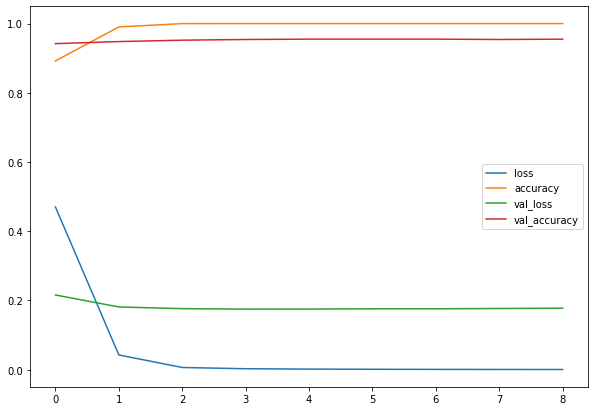

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10,7))

In [ ]:
y_test_arr=[]
a=0
for f in y_test_subset:
  element=y_test_subset[a][0]
  y_test_arr.append(element)
  a=a+1

y_test_arr

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


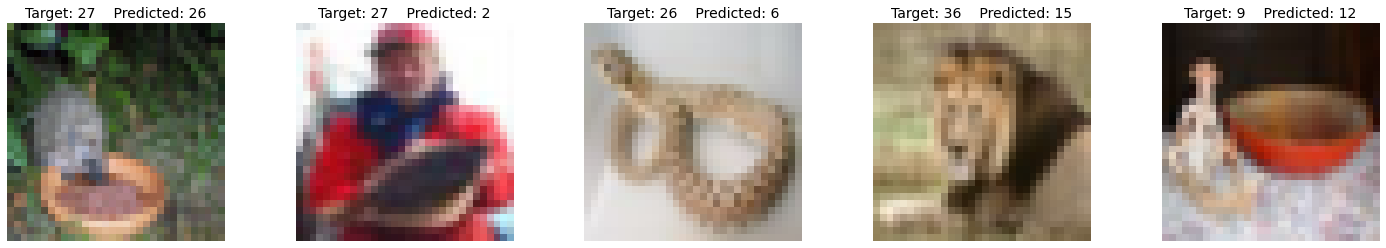

In [ ]:
#Ploting several of the misclassified images from the model


classes = list(range(0, 100))

predictions = np.argmax(model.predict(X_test_subset), axis=-1)
misclassifiedIndexes = []
index = 0
for target, predict in zip(y_test_subset, predictions):
  if target != predict:
    misclassifiedIndexes.append(index)
  index += 1

misclassifiedIndexes

plt.figure(figsize=(25,4))
for index in range(5):
  plt.subplot(1,5,index+1)
  img=X_test[misclassifiedIndexes[index]]/255
  print(img.shape)
  plt.imshow(img, cmap='binary')
  plt.axis('off')
  plt.title(f'Target: {classes[y_test_arr[misclassifiedIndexes[index]]]}    Predicted: {classes[predictions[misclassifiedIndexes[index]]]}', fontsize=14)

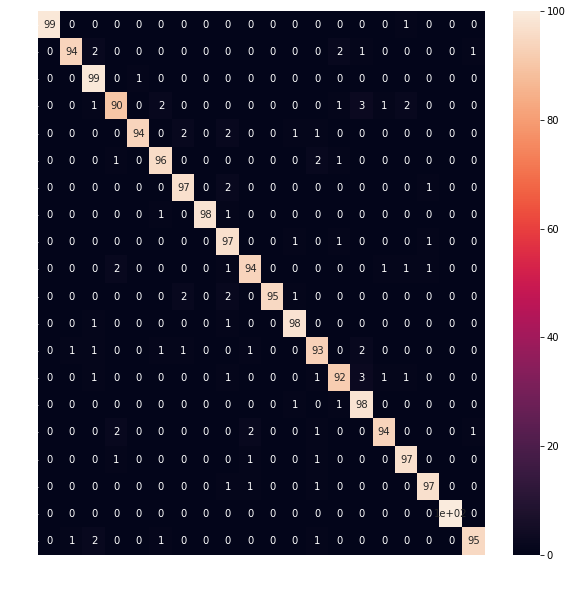

In [ ]:
# Confusion matrix
classes = list(range(0, 20))
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test_subset, np.argmax(model.predict(X_test_subset), axis=-1))
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.ylabel('True class', color='white')
plt.xlabel('Predicted class', color='white')
plt.tick_params(color='white',labelcolor='white')
plt.show()

### For Coarse level of the subset

In [ ]:
#loading data

from sklearn.model_selection import train_test_split
cifar100 = keras.datasets.cifar100
(X_train_full, y_train_full), (X_test, y_test) = cifar100.load_data()


In [ ]:
#Conversion map
fine_id_coarse_id_map = {
    0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7, 8: 18, 9: 3, 10: 3, 11: 14, 12: 9, 13: 18,
    14: 7, 15:11, 16:3, 17: 9, 18: 7, 19: 11, 20: 6,21: 11,22:5, 23:10,24:7,25:6,26:13,27:15,28: 3,
    29: 15,30: 0,31: 11,32: 1, 33: 10, 34: 12,35: 14, 36: 16, 37: 9, 38: 11, 39: 5, 40: 5, 41: 19,42: 8,
    43: 8,44: 15, 45: 13, 46: 14,47: 17,48: 18,49: 10,50: 16,51: 4,52: 17,53: 4,54: 2,55: 0,56: 17,57: 4,
    58: 18,59: 17,60: 10,61: 3,62: 2,63: 12,64: 12,65: 16,66: 12,67: 1,68: 9,69: 19,70: 2,71: 10,72: 0,73: 1,
    74: 16,75: 12,76: 9,77: 13,78: 15,79: 13,80:16, 81:19, 82: 2,83: 4,84: 6,85: 19,86:5,87:5,88:8,89:19,
    90: 18, 91: 1,92: 2,93: 15,94: 6,95: 0,96: 17,97: 8,98: 14, 99: 13
    }

In [ ]:
subset_dict={ 30: 0, 1: 1, 54: 2, 9: 3, 0: 4, 22: 5, 5: 6,6: 7,3: 8,12: 9, 23: 10,15: 11,34: 12,26: 13,2: 14,27: 15,36: 16,47: 17,8: 18,41: 19}


In [ ]:
key_list=list(subset_dict.keys())
key_list

[30, 1, 54, 9, 0, 22, 5, 6, 3, 12, 23, 15, 34, 26, 2, 27, 36, 47, 8, 41]

In [ ]:
#Generating indices for Subset to later application

from pandas.core.arrays import boolean
indices=[]
a=0

for x in y_train_full:
   index= y_train_full[a][0]
   indices.append(index)
   a=a+1

c= np.isin(indices,key_list)

n_indices=np.isin(c, True)

len(n_indices)
#https://stackoverflow.com/questions/1613249/numpy-comparing-elements-in-two-arrays

#https://thispointer.com/find-the-index-of-a-value-in-numpy-array/

50000

In [ ]:
# Obtaining subsets of X_train based corresponding of subset indices
X_train_full_subset = X_train_full[np.where(n_indices)[0]]
y_train_full_subset=y_train_full[np.where(n_indices)[0]]
print(y_train_full_subset)
#print(X_train_full_subset[0])
#https://stackoverflow.com/questions/16222621/get-a-subarray-from-a-numpy-array-based-on-index

[[ 0]
 [ 1]
 [23]
 ...
 [34]
 [26]
 [ 3]]


In [ ]:
def conversionFunction(element):
  for x, y in subset_dict.items():
    if (element==x):
      element=y
      return element

function= np.vectorize(conversionFunction)
y_train_full_subset= function(y_train_full_subset)
y_train_full_subset


#https://www.youtube.com/watch?v=2WardbpK3lk&ab_channel=CodeAltus

array([[ 4],
       [ 1],
       [10],
       ...,
       [12],
       [13],
       [ 8]])

In [ ]:
#Training and validation split

X_train_tr, X_train_v, y_train_tr, y_train_v = train_test_split(X_train_full_subset,
                                                                y_train_full_subset,
                                                                test_size=0.10,
                                                  random_state = 32,
                                                  shuffle=True)

In [ ]:
# Convert from numpy data to tf.data.Dataset
ds_train = tf.data.Dataset.from_tensor_slices( (X_train_tr, y_train_tr) )
ds_valid = tf.data.Dataset.from_tensor_slices((X_train_v, y_train_v))


In [ ]:
# Build transformation pipeline for TFDS Datasets
def preprocess(image, label):
  image = tf.image.resize(image, [224, 224])
  return (image, label)

ds_train = ds_train.map(preprocess)
ds_train = ds_train.batch(32).prefetch(1)
ds_valid = ds_valid.map(preprocess).batch(32).prefetch(1)


In [ ]:
# Use EfficientNet V2
base_model = keras.applications.EfficientNetV2B0(weights="imagenet",
                                              include_top=False,
                                             input_shape=(224,224,3))
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = keras.layers.Dropout(0.05)(global_avg)
output = keras.layers.Dense(100, activation="softmax")(dropout)
model = keras.models.Model(inputs=base_model.input, outputs=output)

# Freeze transferred layers and train

for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy"])

history = model.fit(ds_train,
                    epochs=50, validation_data=ds_valid,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

# Unfreeze layers and train

for layer in base_model.layers:
    layer.trainable = True

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-4), # need smaller lr
                metrics=["accuracy"])

n_epochs = 100
history = model.fit(ds_train,
                    epochs=n_epochs,
                    validation_data=ds_valid,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])
# Converges to ~94% after 1.5 hours (v1 and v2)

Epoch 1/50
282/282 [==============================] - 28s 64ms/step - loss: 0.8607 - accuracy: 0.8248 - val_loss: 0.3598 - val_accuracy: 0.9110
Epoch 2/50
282/282 [==============================] - 16s 58ms/step - loss: 0.2788 - accuracy: 0.9260 - val_loss: 0.2848 - val_accuracy: 0.9220
Epoch 3/50
282/282 [==============================] - 16s 55ms/step - loss: 0.2097 - accuracy: 0.9430 - val_loss: 0.2569 - val_accuracy: 0.9220
Epoch 4/50
282/282 [==============================] - 17s 60ms/step - loss: 0.1704 - accuracy: 0.9548 - val_loss: 0.2436 - val_accuracy: 0.9240
Epoch 5/50
282/282 [==============================] - 16s 56ms/step - loss: 0.1430 - accuracy: 0.9632 - val_loss: 0.2351 - val_accuracy: 0.9240
Epoch 6/50
282/282 [==============================] - 16s 58ms/step - loss: 0.1219 - accuracy: 0.9706 - val_loss: 0.2305 - val_accuracy: 0.9280
Epoch 7/50
282/282 [==============================] - 16s 57ms/step - loss: 0.1055 - accuracy: 0.9754 - val_loss: 0.2291 - val_accuracy:

In [ ]:
from pandas.core.arrays import boolean
indices2=[]
a2=0

for x in y_test:
   index2= y_test[a2][0]
   indices2.append(index2)
   a2=a2+1

c= np.in1d(indices2,key_list)
bool_mask=[]
n_indices2=np.isin(c, True)

len(n_indices2)

10000

In [ ]:
# Obtaining subsets of X_train based corresponding of subset indices
X_test= X_test[np.where(n_indices2)[0]]
y_test=y_test[np.where(n_indices2)[0]]
print(y_test)
#print(X_train_full_subset[0])
#https://stackoverflow.com/questions/16222621/get-a-subarray-from-a-numpy-array-based-on-index

[[15]
 [23]
 [ 0]
 ...
 [30]
 [27]
 [30]]


In [ ]:
def conversionFunction(element):
  for x, y in subset_dict.items():
    if (element==x):
      element=y
      return element

function= np.vectorize(conversionFunction)
y_test= function(y_test)
y_test


#https://www.youtube.com/watch?v=2WardbpK3lk&ab_channel=CodeAltus

array([[11],
       [10],
       [ 4],
       ...,
       [ 0],
       [15],
       [ 0]])

In [ ]:
X_test = tf.image.resize(X_test, [224, 224])

In [ ]:
model.evaluate(X_test, y_test)

63/63 [==============================] - 4s 63ms/step - loss: 0.1559 - accuracy: 0.9550


[0.15585428476333618, 0.9549999833106995]

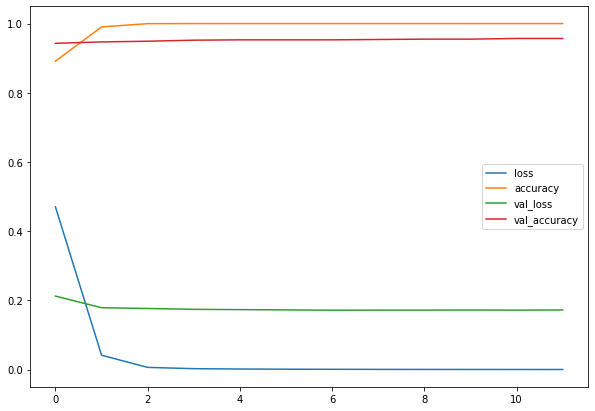

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10,7))

In [ ]:
y_test_arr=[]
a=0
for f in y_test:
  element=y_test[a][0]
  y_test_arr.append(element)
  a=a+1

y_test_arr

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


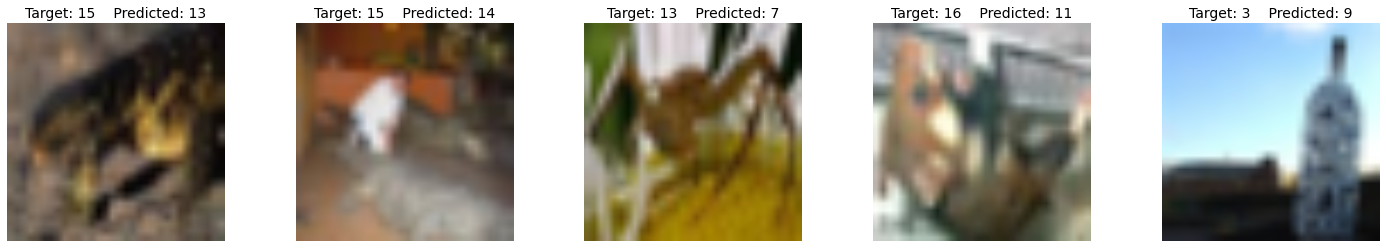

In [ ]:
#Ploting several of the misclassified images from the model


classes = list(range(0, 100))

predictions = np.argmax(model.predict(X_test), axis=-1)
misclassifiedIndexes = []
index = 0
for target, predict in zip(y_test, predictions):
  if target != predict:
    misclassifiedIndexes.append(index)
  index += 1

misclassifiedIndexes

plt.figure(figsize=(25,4))
for index in range(5):
  plt.subplot(1,5,index+1)
  img=X_test[misclassifiedIndexes[index]]/255
  print(img.shape)
  plt.imshow(img, cmap='binary')
  plt.axis('off')
  plt.title(f'Target: {classes[y_test_arr[misclassifiedIndexes[index]]]}    Predicted: {classes[predictions[misclassifiedIndexes[index]]]}', fontsize=14)

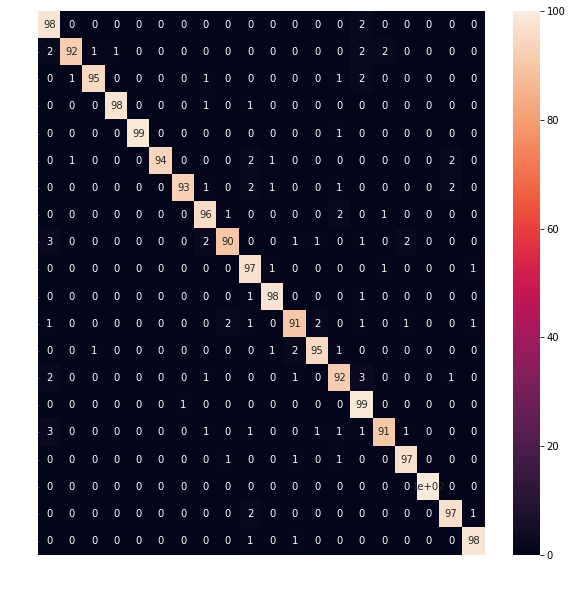

In [ ]:
# Confusion matrix
classes = list(range(0, 20))
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, np.argmax(model.predict(X_test), axis=-1))
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.ylabel('True class', color='white')
plt.xlabel('Predicted class', color='white')
plt.tick_params(color='white',labelcolor='white')
plt.show()

###How much data is require to acheieve previous accuracy?

###Experiment 1: 1/2 of the data

In [ ]:
#loading data

from sklearn.model_selection import train_test_split
cifar100 = keras.datasets.cifar100
(X_train_full, y_train_full), (X_test, y_test) = cifar100.load_data()


In [ ]:
#Conversion map
fine_id_coarse_id_map = {
    0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7, 8: 18, 9: 3, 10: 3, 11: 14, 12: 9, 13: 18,
    14: 7, 15:11, 16:3, 17: 9, 18: 7, 19: 11, 20: 6,21: 11,22:5, 23:10,24:7,25:6,26:13,27:15,28: 3,
    29: 15,30: 0,31: 11,32: 1, 33: 10, 34: 12,35: 14, 36: 16, 37: 9, 38: 11, 39: 5, 40: 5, 41: 19,42: 8,
    43: 8,44: 15, 45: 13, 46: 14,47: 17,48: 18,49: 10,50: 16,51: 4,52: 17,53: 4,54: 2,55: 0,56: 17,57: 4,
    58: 18,59: 17,60: 10,61: 3,62: 2,63: 12,64: 12,65: 16,66: 12,67: 1,68: 9,69: 19,70: 2,71: 10,72: 0,73: 1,
    74: 16,75: 12,76: 9,77: 13,78: 15,79: 13,80:16, 81:19, 82: 2,83: 4,84: 6,85: 19,86:5,87:5,88:8,89:19,
    90: 18, 91: 1,92: 2,93: 15,94: 6,95: 0,96: 17,97: 8,98: 14, 99: 13
    }

In [ ]:
subset_dict={ 30: 0, 1: 1, 54: 2, 9: 3, 0: 4, 22: 5, 5: 6,6: 7,3: 8,12: 9, 23: 10,15: 11,34: 12,26: 13,2: 14,27: 15,36: 16,47: 17,8: 18,41: 19}


In [ ]:
key_list=list(subset_dict.keys())
key_list

[30, 1, 54, 9, 0, 22, 5, 6, 3, 12, 23, 15, 34, 26, 2, 27, 36, 47, 8, 41]

In [ ]:
#Generating indices for Subset to later application

from pandas.core.arrays import boolean

allIndices=[]
for i in range(len(key_list)):
  indices_commonLabel=[]
  a=0
  for j in range(len(y_train_full)):
   if (key_list[i]==y_train_full[a][0]):
     indices_commonLabel.append(j)
   a=a+1
  indices_commonLabel=indices_commonLabel[:250]
  for each in indices_commonLabel:
     allIndices.append(each)

X_train_full_subset_oneFourth = X_train_full[np.where(allIndices)[0]]
y_train_full_subset_oneFourth = y_train_full[np.where(allIndices)[0]]



   #All_common_indices.append(indices_commonLabel)




#https://stackoverflow.com/questions/1613249/numpy-comparing-elements-in-two-arrays

#https://thispointer.com/find-the-index-of-a-value-in-numpy-array/

In [ ]:
#Training and validation split

X_train_tr, X_train_v, y_train_tr, y_train_v = train_test_split(X_train_full_subset_oneFourth,
                                                                y_train_full_subset_oneFourth,

                                                  random_state = 32,
                                                  shuffle=True)

In [ ]:
# Convert from numpy data to tf.data.Dataset
ds_train = tf.data.Dataset.from_tensor_slices( (X_train_tr, y_train_tr) )
ds_valid = tf.data.Dataset.from_tensor_slices((X_train_v, y_train_v))

# Build transformation pipeline for TFDS Datasets
def preprocess(image, label):
  image = tf.image.resize(image, [224, 224])
  return (image, label)

ds_train = ds_train.map(preprocess)
ds_train = ds_train.batch(32).prefetch(1)
ds_valid = ds_valid.map(preprocess).batch(32).prefetch(1)



In [ ]:
# Use EfficientNet V2
base_model = keras.applications.EfficientNetV2B0(weights="imagenet",
                                              include_top=False,
                                             input_shape=(224,224,3))
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = keras.layers.Dropout(0.05)(global_avg)
output = keras.layers.Dense(100, activation="softmax")(dropout)
model = keras.models.Model(inputs=base_model.input, outputs=output)

# Freeze transferred layers and train

for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy"])

history = model.fit(ds_train,
                    epochs=50, validation_data=ds_valid,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

# Unfreeze layers and train

for layer in base_model.layers:
    layer.trainable = True

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-4), # need smaller lr
                metrics=["accuracy"])

n_epochs = 100
history = model.fit(ds_train,
                    epochs=n_epochs,
                    validation_data=ds_valid,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])
# Converges to ~94% after 1.5 hours (v1 and v2)

Epoch 1/50
118/118 [==============================] - 16s 87ms/step - loss: 3.2454 - accuracy: 0.3272 - val_loss: 2.2928 - val_accuracy: 0.5032
Epoch 2/50
118/118 [==============================] - 8s 67ms/step - loss: 1.5810 - accuracy: 0.6667 - val_loss: 1.7493 - val_accuracy: 0.5552
Epoch 3/50
118/118 [==============================] - 8s 67ms/step - loss: 1.0984 - accuracy: 0.7659 - val_loss: 1.5760 - val_accuracy: 0.5776
Epoch 4/50
118/118 [==============================] - 9s 74ms/step - loss: 0.8505 - accuracy: 0.8216 - val_loss: 1.4972 - val_accuracy: 0.5784
Epoch 5/50
118/118 [==============================] - 8s 67ms/step - loss: 0.6871 - accuracy: 0.8608 - val_loss: 1.4542 - val_accuracy: 0.5880
Epoch 6/50
118/118 [==============================] - 8s 66ms/step - loss: 0.5650 - accuracy: 0.8976 - val_loss: 1.4306 - val_accuracy: 0.5960
Epoch 7/50
118/118 [==============================] - 8s 66ms/step - loss: 0.4737 - accuracy: 0.9216 - val_loss: 1.4183 - val_accuracy: 0.595

In [ ]:
#Generating indices for Subset to later application

from pandas.core.arrays import boolean

allIndices=[]
for i in range(len(key_list)):
  indices_commonLabel=[]
  a=0
  for j in range(len(y_test)):
   if (key_list[i]==y_test[a][0]):
     indices_commonLabel.append(j)
   a=a+1
  indices_commonLabel=indices_commonLabel[:250]
  for each in indices_commonLabel:
     allIndices.append(each)

X_test_subset_oneFourth = X_test[np.where(allIndices)[0]]
y_test_subset_oneFourth = y_test[np.where(allIndices)[0]]

In [ ]:
X_test_subset_oneFourth = tf.image.resize(X_test_subset_oneFourth, [224, 224])


In [ ]:
model.evaluate(X_test_subset_oneFourth, y_test_subset_oneFourth)

63/63 [==============================] - 4s 64ms/step - loss: 1.2012 - accuracy: 0.6950


[1.2012265920639038, 0.6949999928474426]

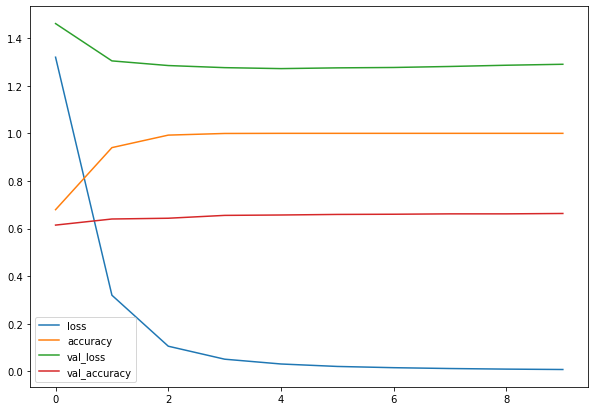

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10,7))

###Experiment 2: one half of the data

In [ ]:
#Generating indices for Subset to later application

from pandas.core.arrays import boolean

allIndices=[]
for i in range(len(key_list)):
  indices_commonLabel=[]
  a=0
  for j in range(len(y_train_full)):
   if (key_list[i]==y_train_full[a][0]):
     indices_commonLabel.append(j)
   a=a+1
  indices_commonLabel=indices_commonLabel[:375]
  for each in indices_commonLabel:
     allIndices.append(each)

X_train_full_subset_oneFourth = X_train_full[np.where(allIndices)[0]]
y_train_full_subset_oneFourth = y_train_full[np.where(allIndices)[0]]



In [ ]:
#Training and validation split

X_train_tr, X_train_v, y_train_tr, y_train_v = train_test_split(X_train_full_subset_oneFourth,
                                                                y_train_full_subset_oneFourth,

                                                  random_state = 32,
                                                  shuffle=True)

In [ ]:
# Convert from numpy data to tf.data.Dataset
ds_train = tf.data.Dataset.from_tensor_slices( (X_train_tr, y_train_tr) )
ds_valid = tf.data.Dataset.from_tensor_slices((X_train_v, y_train_v))

# Build transformation pipeline for TFDS Datasets
def preprocess(image, label):
  image = tf.image.resize(image, [224, 224])
  return (image, label)

ds_train = ds_train.map(preprocess)
ds_train = ds_train.batch(32).prefetch(1)
ds_valid = ds_valid.map(preprocess).batch(32).prefetch(1)


In [ ]:
# Use EfficientNet V2
base_model = keras.applications.EfficientNetV2B0(weights="imagenet",
                                              include_top=False,
                                             input_shape=(224,224,3))
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = keras.layers.Dropout(0.05)(global_avg)
output = keras.layers.Dense(100, activation="softmax")(dropout)
model = keras.models.Model(inputs=base_model.input, outputs=output)

# Freeze transferred layers and train

for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy"])

history = model.fit(ds_train,
                    epochs=50, validation_data=ds_valid,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

# Unfreeze layers and train

for layer in base_model.layers:
    layer.trainable = True

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-4), # need smaller lr
                metrics=["accuracy"])

n_epochs = 100
history = model.fit(ds_train,
                    epochs=n_epochs,
                    validation_data=ds_valid,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])
# Converges to ~94% after 1.5 hours (v1 and v2)

24289280/24274472 [==============================] - 0s 0us/step
Epoch 1/50
176/176 [==============================] - 28s 77ms/step - loss: 2.8450 - accuracy: 0.3988 - val_loss: 1.8466 - val_accuracy: 0.5653
Epoch 2/50
176/176 [==============================] - 11s 64ms/step - loss: 1.3489 - accuracy: 0.6869 - val_loss: 1.4677 - val_accuracy: 0.6101
Epoch 3/50
176/176 [==============================] - 12s 66ms/step - loss: 0.9820 - accuracy: 0.7621 - val_loss: 1.3446 - val_accuracy: 0.6277
Epoch 4/50
176/176 [==============================] - 11s 65ms/step - loss: 0.7848 - accuracy: 0.8160 - val_loss: 1.2885 - val_accuracy: 0.6309
Epoch 5/50
176/176 [==============================] - 14s 78ms/step - loss: 0.6445 - accuracy: 0.8564 - val_loss: 1.2571 - val_accuracy: 0.6379
Epoch 6/50
176/176 [==============================] - 12s 67ms/step - loss: 0.5395 - accuracy: 0.8894 - val_loss: 1.2415 - val_accuracy: 0.6432
Epoch 7/50
176/176 [==============================] - 14s 80ms/step - l

In [ ]:
#Generating indices for Subset to later application

from pandas.core.arrays import boolean

allIndices=[]
for i in range(len(key_list)):
  indices_commonLabel=[]
  a=0
  for j in range(len(y_test)):
   if (key_list[i]==y_test[a][0]):
     indices_commonLabel.append(j)
   a=a+1
  indices_commonLabel=indices_commonLabel[:250]
  for each in indices_commonLabel:
     allIndices.append(each)

X_test_subset_oneFourth = X_test[np.where(allIndices)[0]]
y_test_subset_oneFourth = y_test[np.where(allIndices)[0]]

In [ ]:
X_test_subset_oneFourth = tf.image.resize(X_test_subset_oneFourth, [224, 224])


In [ ]:
model.evaluate(X_test_subset_oneFourth, y_test_subset_oneFourth)

63/63 [==============================] - 4s 63ms/step - loss: 1.0933 - accuracy: 0.7170


[1.0932626724243164, 0.7170000076293945]

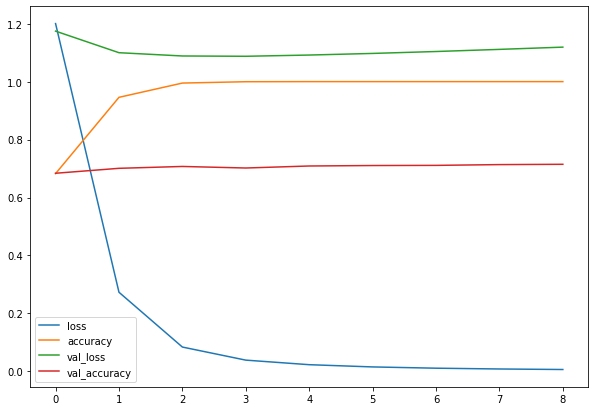

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10,7))

In [ ]:
#Generating indices for Subset to later application

from pandas.core.arrays import boolean

allIndices=[]
for i in range(len(key_list)):
  indices_commonLabel=[]
  a=0
  for j in range(len(y_train_full)):
   if (key_list[i]==y_train_full[a][0]):
     indices_commonLabel.append(j)
   a=a+1
  indices_commonLabel=indices_commonLabel[:450]
  for each in indices_commonLabel:
     allIndices.append(each)

X_train_full_subset_oneFourth = X_train_full[np.where(allIndices)[0]]
y_train_full_subset_oneFourth = y_train_full[np.where(allIndices)[0]]

In [ ]:
#Training and validation split

X_train_tr, X_train_v, y_train_tr, y_train_v = train_test_split(X_train_full_subset_oneFourth,
                                                                y_train_full_subset_oneFourth,

                                                  random_state = 32,
                                                  shuffle=True)

In [ ]:
# Convert from numpy data to tf.data.Dataset
ds_train = tf.data.Dataset.from_tensor_slices( (X_train_tr, y_train_tr) )
ds_valid = tf.data.Dataset.from_tensor_slices((X_train_v, y_train_v))

# Build transformation pipeline for TFDS Datasets
def preprocess(image, label):
  image = tf.image.resize(image, [224, 224])
  return (image, label)

ds_train = ds_train.map(preprocess)
ds_train = ds_train.batch(32).prefetch(1)
ds_valid = ds_valid.map(preprocess).batch(32).prefetch(1)

In [ ]:
# Use EfficientNet V2
base_model = keras.applications.EfficientNetV2B0(weights="imagenet",
                                              include_top=False,
                                             input_shape=(224,224,3))
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = keras.layers.Dropout(0.05)(global_avg)
output = keras.layers.Dense(100, activation="softmax")(dropout)
model = keras.models.Model(inputs=base_model.input, outputs=output)

# Freeze transferred layers and train

for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy"])

history = model.fit(ds_train,
                    epochs=50, validation_data=ds_valid,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

# Unfreeze layers and train

for layer in base_model.layers:
    layer.trainable = True

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-4), # need smaller lr
                metrics=["accuracy"])

n_epochs = 100
history = model.fit(ds_train,
                    epochs=n_epochs,
                    validation_data=ds_valid,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])
# Converges to ~94% after 1.5 hours (v1 and v2)

Epoch 1/50
211/211 [==============================] - 23s 78ms/step - loss: 2.6490 - accuracy: 0.4270 - val_loss: 1.7238 - val_accuracy: 0.5827
Epoch 2/50
211/211 [==============================] - 15s 69ms/step - loss: 1.2662 - accuracy: 0.6880 - val_loss: 1.3986 - val_accuracy: 0.6218
Epoch 3/50
211/211 [==============================] - 15s 70ms/step - loss: 0.9429 - accuracy: 0.7667 - val_loss: 1.2896 - val_accuracy: 0.6418
Epoch 4/50
211/211 [==============================] - 16s 77ms/step - loss: 0.7575 - accuracy: 0.8154 - val_loss: 1.2353 - val_accuracy: 0.6547
Epoch 5/50
211/211 [==============================] - 14s 68ms/step - loss: 0.6303 - accuracy: 0.8572 - val_loss: 1.2055 - val_accuracy: 0.6578
Epoch 6/50
211/211 [==============================] - 14s 68ms/step - loss: 0.5299 - accuracy: 0.8812 - val_loss: 1.1878 - val_accuracy: 0.6618
Epoch 7/50
211/211 [==============================] - 14s 68ms/step - loss: 0.4505 - accuracy: 0.9062 - val_loss: 1.1798 - val_accuracy:

In [ ]:
X_test_subset_oneFourth = tf.image.resize(X_test_subset_oneFourth, [224, 224])


In [ ]:
model.evaluate(X_test_subset_oneFourth, y_test_subset_oneFourth)

63/63 [==============================] - 4s 56ms/step - loss: 1.0765 - accuracy: 0.7395


[1.07652747631073, 0.7394999861717224]

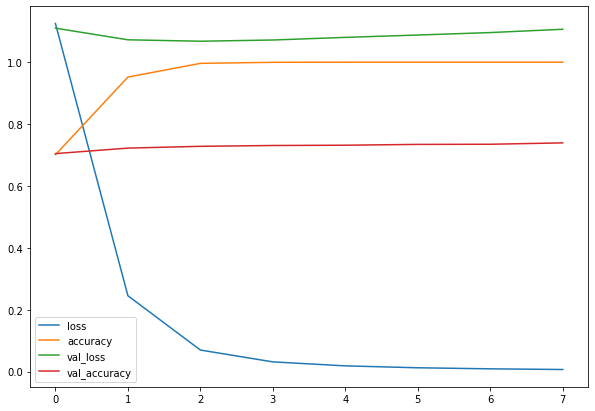

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10,7))

In [ ]:
#Generating indices for Subset to later application

from pandas.core.arrays import boolean

allIndices=[]
for i in range(len(key_list)):
  indices_commonLabel=[]
  a=0
  for j in range(len(y_train_full)):
   if (key_list[i]==y_train_full[a][0]):
     indices_commonLabel.append(j)
   a=a+1
  indices_commonLabel=indices_commonLabel[:495]
  for each in indices_commonLabel:
     allIndices.append(each)

X_train_full_subset_oneFourth = X_train_full[np.where(allIndices)[0]]
y_train_full_subset_oneFourth = y_train_full[np.where(allIndices)[0]]

In [ ]:
#Training and validation split

X_train_tr, X_train_v, y_train_tr, y_train_v = train_test_split(X_train_full_subset_oneFourth,
                                                                y_train_full_subset_oneFourth,

                                                  random_state = 32,
                                                  shuffle=True)

In [ ]:
# Convert from numpy data to tf.data.Dataset
ds_train = tf.data.Dataset.from_tensor_slices( (X_train_tr, y_train_tr) )
ds_valid = tf.data.Dataset.from_tensor_slices((X_train_v, y_train_v))

# Build transformation pipeline for TFDS Datasets
def preprocess(image, label):
  image = tf.image.resize(image, [224, 224])
  return (image, label)

ds_train = ds_train.map(preprocess)
ds_train = ds_train.batch(32).prefetch(1)
ds_valid = ds_valid.map(preprocess).batch(32).prefetch(1)

In [ ]:
# Use EfficientNet V2
base_model = keras.applications.EfficientNetV2B0(weights="imagenet",
                                              include_top=False,
                                             input_shape=(224,224,3))
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = keras.layers.Dropout(0.05)(global_avg)
output = keras.layers.Dense(100, activation="softmax")(dropout)
model = keras.models.Model(inputs=base_model.input, outputs=output)

# Freeze transferred layers and train

for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy"])

history = model.fit(ds_train,
                    epochs=50, validation_data=ds_valid,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

# Unfreeze layers and train

for layer in base_model.layers:
    layer.trainable = True

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-4), # need smaller lr
                metrics=["accuracy"])

n_epochs = 100
history = model.fit(ds_train,
                    epochs=n_epochs,
                    validation_data=ds_valid,
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])
# Converges to ~94% after 1.5 hours (v1 and v2)

Epoch 1/50
233/233 [==============================] - 23s 76ms/step - loss: 2.5667 - accuracy: 0.4501 - val_loss: 1.6045 - val_accuracy: 0.6073
Epoch 2/50
233/233 [==============================] - 17s 74ms/step - loss: 1.2385 - accuracy: 0.6924 - val_loss: 1.3121 - val_accuracy: 0.6428
Epoch 3/50
233/233 [==============================] - 16s 68ms/step - loss: 0.9352 - accuracy: 0.7616 - val_loss: 1.2179 - val_accuracy: 0.6566
Epoch 4/50
233/233 [==============================] - 16s 67ms/step - loss: 0.7584 - accuracy: 0.8088 - val_loss: 1.1732 - val_accuracy: 0.6651
Epoch 5/50
233/233 [==============================] - 16s 69ms/step - loss: 0.6296 - accuracy: 0.8510 - val_loss: 1.1490 - val_accuracy: 0.6727
Epoch 6/50
233/233 [==============================] - 17s 74ms/step - loss: 0.5347 - accuracy: 0.8809 - val_loss: 1.1373 - val_accuracy: 0.6764
Epoch 7/50
233/233 [==============================] - 16s 68ms/step - loss: 0.4585 - accuracy: 0.9044 - val_loss: 1.1336 - val_accuracy:

KeyboardInterrupt: ignored